<a href="https://colab.research.google.com/github/jon-pun/Spring-2023-ORIE-4741/blob/main/HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ORIE 4580/5580 Assignment 6

#### Student: Jonathan Yun (jly37)

### Github link: [here!](https://github.com/jon-pun/Spring-2023-ORIE-4741/blob/main/HW6.ipynb)


### Instructions


* Due Tuesday, November 14, at 11.59pm on Gradescope.
* Assignment .ipynb files available for download on [Canvas](https://canvas.cornell.edu/courses/56826#:~:text=Assignments-,Assignments,-Assignments%20Module%20publish). Do all your work in provided notebook (text answers typeset in markdown; show all required code and generate plots inline), and then generate and submit a pdf.
* Ideally do assignments in groups of 2, and submit a single pdf with both names
* Please show your work and clearly mark your answers.
* You can use any code fragments given in class, found online (for example, on StackOverflow), or generated via Bard or ChatGPT (you are encouraged to use these for first drafts) **with proper referencing**. You can also discuss with others (again, please reference them if you do so); but you must write your final answers on your own as a team.



### Suggested reading

[Mor Harchol-Balter's chapter](https://canvas.cornell.edu/courses/56826/files/9180297/download?download_frd=1) on the Poisson process (on Canvas)

___
___

# Question 1: Everyone goes to Gimme! (25 points)

The downtown Ithaca Gimme! store sees a Poisson arrival process with rate

$$ \lambda(t)=\frac{1}{56}\left(5t^3-90t^2+300t+1480\right) \quad \text{for } 0 \leq t \leq 12,$$

over the 12 hours on the weekdays it is open.


___

**(a)** Compute the exact probability that the coffee store will see more than 250 customers in one 12 hour day. Do not use simulation.
___


## Ans.

In [2]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc

To determine the probability that Gimme! will see more than 250 customers in one 12-hour day, let's determine the rate process of the Poisson for this time period.

To do that, we know that the resulting Poisson, for some times $t_1$ and $t_2$, should have a parameter equal to $\int_{t_1}^{t_2}\lambda(t) dt$.

Thus, we can say that

$$
\int_{t_1}^{t_2}\lambda(t) dt = \int_{0}^{12} \frac{1}{56} (5t^3 - 90t^2 + 300t - 1480) dt
= \frac{1}{56}  \int_{0}^{12}5t^3 - 90t^2 + 300t - 1480 dt =
\frac{1}{56} [\frac{5}{4} t^4 - 30t^3 + 150t^2 + 1480t]^{t = 12}_{t = 0} = \frac{(13440 - 0)}{56} = 240
$$

and thus we know that the resulting Poisson exists with a rate parameter of 240.

If $X$ represents the number of arrivals, then we can find $P(X > 250)$ by finding $1 - P(X \leq 250)$, as $1 - P(Poi(240) \leq 250)$, or as follows:


In [3]:
1 - sc.stats.poisson(mu = 240).cdf(250)

0.24711253205956696

So, the actual probability of having more than 250 customers in one 12-hour day is $0.2471$.

___

**(b)** Use thinning to simulate 500 replications of the Poisson arrival process. Based on these replications, estimate the probability in Part (a) and report a 95\% confidence interval.

___

## Ans.



In [27]:
# for the poisson rate function
def poiss_rate(t):
  return 1/56 * (5*t**3 - 90*t**2 + 300*t + 1480)

In [37]:
poiss_rate(0)

26.428571428571427

In [42]:
# output arrays
custs = []
raw_arrivals = []

# doing the simulation itself
for i in range(500):
  time = 0

  # setting lambda star for the thnning method
  lambda_star = 35

  arrivals = list()


  while(time <= 12):
    interarrival = np.random.exponential(1/lambda_star)
    time += interarrival

    #checking for success?
    unif = np.random.uniform()

    if(unif <= (poiss_rate(time) / lambda_star)):

      arrivals.append(time + interarrival)

  custs.append(len(arrivals))
  raw_arrivals.append(arrivals)

In [43]:
print("Estimated probability: {:.5f}".format(np.sum(pd.Series(custs) > 250) / 500))


Estimated probability: 0.24200


In [44]:
mu_N = np.sum(pd.Series(custs) > 250) / len(custs)
std_N = np.std(pd.Series(custs) > 250) / np.sqrt(len(custs))


lower_bound = mu_N - 1.96 * std_N
upper_bound = mu_N + 1.96 * std_N

print("95% confidence interval: ({:.4f},{:.4f})".format(lower_bound, upper_bound))


95% confidence interval: (0.2045,0.2795)


___
**(c)** Based on your 500 replications, make a bar plot showing the average number of customers who arrive during each of the twelve hours of operation. Plot the rate function $\lambda(t)$ and compare.
___

## Ans.

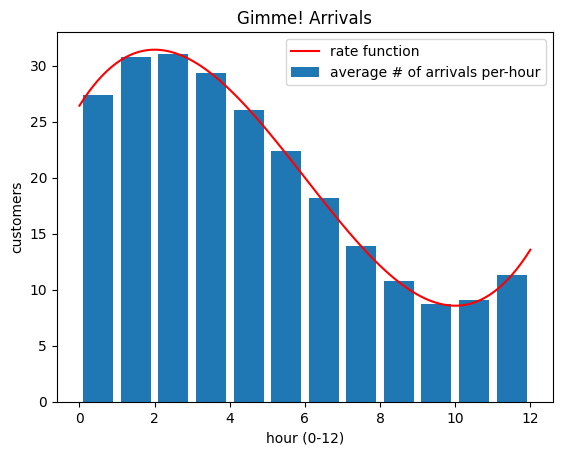

In [45]:
# plotting the rate function
plt.plot(np.linspace(0,12,100), poiss_rate(np.linspace(0,12,100)), label = 'rate function', c = "red")

# plotting average arrivals

raw_arrivals = pd.DataFrame(raw_arrivals)

average_per_hour = []

for i in range(12):
  average_per_hour.append(((i <= raw_arrivals) & (raw_arrivals < i + 1)).sum().sum() / len(custs))

# adding 0.5 to the bar plot should allow for more accurate spacing (eg. 0-1 hour actually occupies that space, not on the "0")
plt.bar(np.linspace(0,11,12) + 0.5, average_per_hour, label = "average # of arrivals per-hour")
plt.title("Gimme! Arrivals")
plt.xlabel("hour (0-12)")
plt.ylabel("customers")
# showing results
plt.legend()
plt.show()


Perhaps rather sensically, the average number of arrivals at any given hour within the simulation closely matches the average value of the rate function in that given hour.




---
---


# Question 2: Putting my son to bed (30 points)

Sid uses a Spotify playlist with $n$ soothing songs to put his son to sleep. He plays the playlist on shuffle, but is worried that some songs may not get played (he spent a long time curating the playlist!).

___
**(a)**
Suppose Spotify truly picks a random song each time -- Sid wants to know how many songs it takes on average to play **every song** on his playlist. Build a simulator to estimate this for a different values of $n$, and use this to try and guess the function.

*Note: Try and pick a large range of $n$ to get a sense of the function of number of songs needed to play all vs. $n$ -- if you are adventurous, try to fit the function. Make sure you always show your CIs!*
___

## Ans.


In [56]:
def simul_2a(n):

  # create an array for the visits
  visits = []

  # create an array for the numbers to check against
  songs = np.linspace(0,n - 1, n)

  # start iterating!
  while(True):
    visits.append(np.random.randint(0,n))

    # check if every song has been played
    if (np.sum(np.isin(songs, visits)) == n):
      break

  return len(visits)

In [67]:
simul_2a(10)

28

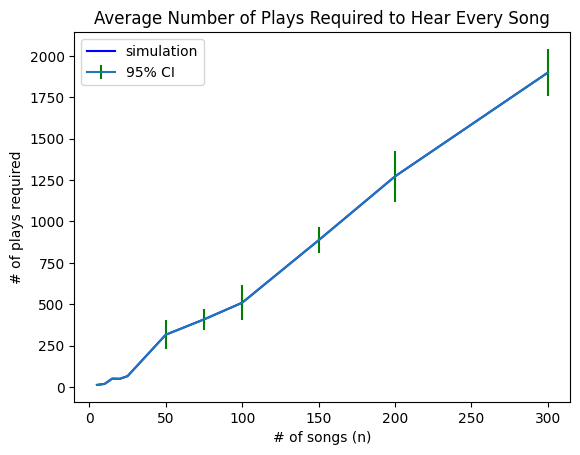

In [135]:
# now, using this to simulate many times, across values of n
n_to_test = [5, 10, 15, 20, 25, 50, 75, 100, 150, 200, 300]
est = []
std = []

for i in range(len(n_to_test)):

  n = n_to_test[i]

  # pilot run
  results = []
  for j in range(20):
    results.append(simul_2a(int(n)))

  std_k = np.std(results)


  # changing N so the sample size decreases -- CI fitting to half-width of 100
  N = int(np.ceil(1.96**2 * std_k**2 / (100**2)))

  # real run
  results = []
  for j in range(N):
    results.append(simul_2a(int(n)))

  # get statistics
  mu_N = np.mean(results)
  std_N = np.std(results)


  # store the value for plotting
  # store the standard deviation for the CI
  est.append(mu_N)
  std.append(std_N / np.sqrt(N))


# plot the simulated means for each value of n
plt.plot(n_to_test, est, label = 'simulation', color = 'blue')
# add the 95% confidence intervals!
plt.errorbar(n_to_test, est, yerr = 1.96 * np.array(std), ecolor = 'green', label = "95% CI")

plt.title("Average Number of Plays Required to Hear Every Song")
plt.xlabel("# of songs (n)")
plt.ylabel("# of plays required")
plt.legend()

plt.show()

Ultimately, it seems that this function is **roughly linear?** As n increases, then number of plays required also increases with it in a directly proportional manner. It could be said that this is perhaps the beginning of an exponential / quadratic function, but I think this could only be proved by simulating a very large number of songs (think in the thousands) -- which would require an incredibly long simulation time to finish seeing every number.

___

**(b)** On the other hand, Sid has realized that his son wakes up whenever he hears a song that has been played before (clever, isn't he!). Use your previous simulator to figure out how many songs Sid's son hears before he wakes up.

___

## Ans.



In [119]:
def simul_2b(n):

  # create an array for the visits
  visits = []

  # create an array for the numbers to check against
  songs = np.linspace(0,n - 1, n)

  # start iterating!
  while(True):

    visit = np.random.randint(0,n)

    # check if a song has been played before
    if (np.sum(np.isin(visit, visits)) == 1):
      break
    visits.append(visit)

  return len(visits)

In [120]:
simul_2b(5)

3

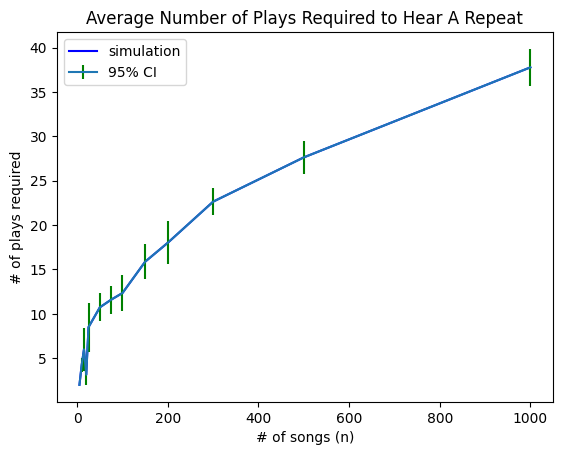

In [141]:
# now, using this to simulate many times, across values of n
n_to_test = [5, 10, 15, 20, 25, 50, 75, 100, 150, 200, 300, 500, 1000]
est = []
std = []

for i in range(len(n_to_test)):

  n = n_to_test[i]

  # pilot run
  results = []
  for j in range(20):
    results.append(simul_2b(int(n)))

  std_k = np.std(results)


  # changing N so the sample size decreases -- CI fitting to half-width of 2
  N = int(np.ceil(1.96**2 * std_k**2 / (2**2)))

  # real run
  results = []
  for j in range(N):
    results.append(simul_2b(int(n)))

  # get statistics
  mu_N = np.mean(results)
  std_N = np.std(results / np.sqrt(N))


  # store the value for plotting
  # store the standard deviation for the CI
  est.append(mu_N)
  std.append(std_N)


# plot the simulated means for each value of n
plt.plot(n_to_test, est, label = 'simulation', color = 'blue')
# add the 95% confidence intervals!
plt.errorbar(n_to_test, est, yerr = 1.96 * np.array(std), ecolor = 'green', label = "95% CI")

plt.title("Average Number of Plays Required to Hear A Repeat")
plt.xlabel("# of songs (n)")
plt.ylabel("# of plays required")
plt.legend()

plt.show()

Ultimately, it seems that this function is **roughly proportional to the square root function?** As n increases, then number of plays required also increases, but the curve gets "flatter" over time.

___

**(c)** Suppose Spotify uses the following poor randomizer: it labels songs as $\{0,1,2,\ldots,n-1\}$, and after playing a song $i$, it then either plays song $(i+1) mod(n)$ or $(i-1)mod(n)$ with probability $1/2$ (i.e., the next or previous song, imagining the songs to be in a ring with $n-1$ wrapping around to $1$). Simulate this randomizer for $n=20$, assuming you always start at song $1$, and find the histogram of the **last song to be played** for the first time using this shuffler.   

___

## Ans.

In [164]:
def simul_2c():

  # create an array for the visits
  visits = [1]

  # create an array for the numbers to check against
  songs = np.linspace(0,19, 20)

  # start iterating!
  while(True):
    probability = np.random.uniform()
    if(probability < 0.5):
      visit = visits[len(visits) - 1] + 1 % n
    else:
      visit = visits[len(visits) - 1] - 1 % n
    if(visit < 0):
        visit = 20 + visit
    elif(visit >= 20):
        visit = visit - 20

    visits.append(visit)
    #print(visits)
    # check if a song is a repeat
    if (np.sum(np.isin(songs, visits)) == n):
      break
  return visits[len(visits) - 2]

In [165]:
simul_2c()

17

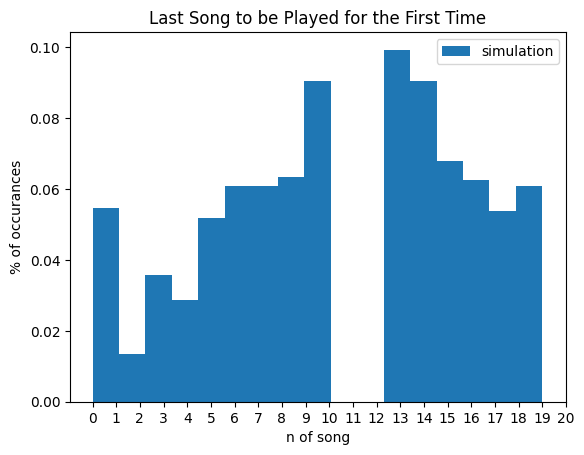

In [171]:
# now, using this to simulate many times, across values of n
n_to_test = 20

results = np.zeros(1000)
for i in range(1000):
  results[i] = simul_2c()
# plot the simulated means for each value of n
plt.hist(results, label = 'simulation', bins = len(np.unique(results)), density = True)

plt.title("Last Song to be Played for the First Time")
plt.xticks(np.linspace(0,20,21))
plt.xlabel("n of song")
plt.ylabel("% of occurrances")
plt.legend()

plt.show()

___

**(d) (OPTIONAL)** For the above three questions, try and analytically derive the functions that you should get (and compare)

___
___

# Question 3: The gambler's ruin (20 points)

The gambler's ruin is one of the most famous and widely studied models in stochastic processes. Imagine two gamblers $A$ and $B$ are playing a tournament, where they each start with \$$a$ and \$$b$ initially, and play a sequence of games, where each game is won by either player with probability $1/2$, with the winner giving \$$1$ to the loser. Play goes on till one player runs out of money.

___

**(a)** Simulate this model to find the probability that player $A$ wins the overall tournament. Also, try and derive this analytically, and see how well the two match up.

___

## Ans.

In [173]:
# building one simulation out

def gamble(a, b):
  a_dollars = a
  b_dollars = b
  flips = 0

  # a wins on [0, 0.5)
  # b wins on [0.5, 1)

  while(True):
    flip = np.random.uniform()
    flips += 1

    if(flip < 0.5):
      a += 1
      b -= 1
    else:
      a -= 1
      b += 1

    if(a == 0 or b == 0):
      break

  return [b == 0, flips]


In [177]:
gamble(5,5)

[False, 11]

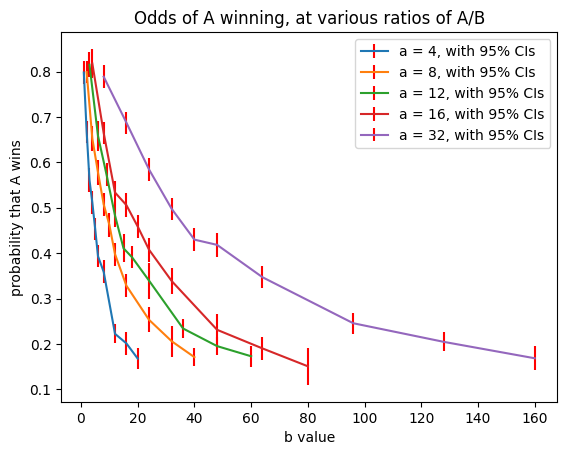

In [192]:
# now, simulating and plotting out the probabilities of A winning

a_values = [4, 8, 12, 16, 32]

for i in range(len(a_values)):
  a_val = a_values[i]

  b_values = [a_val * 0.25, a_val * 0.5, a_val * 0.75, a_val, a_val * 1.25, a_val * 1.5, a_val * 2, a_val * 3, a_val * 4, a_val * 5]

  est = []
  std = []

  for j in range(len(b_values)):
    # pilot run
    results = []
    for k in range(20):
      results.append(gamble(a_val, b_values[j])[0])

    std_k = np.std(results)


    # changing N so the sample size decreases -- CI fitting to half-width of 0.05
    N = int(np.ceil(1.96**2 * std_k**2 / (0.025**2)))

    # real run
    results = []
    for k in range(N):
      results.append(gamble(a_val, b_values[j])[0])

    # get statistics
    mu_N = np.mean(results)
    std_N = np.std(results)


    # store the value for plotting
    # store the standard deviation for the CI
    est.append(mu_N)
    std.append(std_N / np.sqrt(N))


  # plot the simulated odds of winning for this value of a
  #plt.plot(b_values, est, label = 'a = {}'.format(a_val))
  # add the 95% confidence intervals!
  plt.errorbar(b_values, est, yerr = 1.96 * np.array(std), ecolor = 'red', label = 'a = {}, with 95% CIs'.format(a_val))

  plt.legend()
  plt.xlabel("b value")
  plt.ylabel("probability that A wins")
  plt.title("Odds of A winning, at various ratios of A/B")


plt.show()

**Thinking about this analytically:**

If we go back to ORIE 3510, this is basically a random walk, and so... it could be reasonably considered to be a Markov chain (DTMC)?

Think of the state space here as (say, for a = 4, b = 4), equal to the possible values of:

(0,8) (1,7) (2,6), (3,5) (4,4) (5,3) (6,2), (1,7) (8,0)

in which the probability of moving left (towards A winning) is $1/2$, and the odds of moving right are also $1/2$.

If we use the cut method on this Markov Chain (between each state), we find that each $\pi_i$ in the stationary distribution should be equal, except at the ends:

Between (0,8) and (1,7), we see that $0*\pi_{(0,8)} = 1*\pi_{(1,7)}$, and the same is true in reverse at the other end of the Markov Chain ($0*\pi_{(8,0)} = 1*\pi_{(7,1)}$), and thus the stationary distribution is full of $0$s in the middle, and has set probabilities on either end (what we expect).

These probabilities are actually dependent on where you start in the DTMC: if the initial state is, say, $(4,4)$, then both odds are $0.5$ (what you expect), but if you start anywhere else, it depends on how far "off-center" you are; specifically, for any value of $a$ and $b$, I'd think the odds of reaching a state in which a wins (so, $(a+b, 0)$) are actually $\frac{a}{a + b}$.

This matches what we see in the above: if we plot out the ratios of $\frac{a}{a + b}$ that I've chosen, you'll see the above:




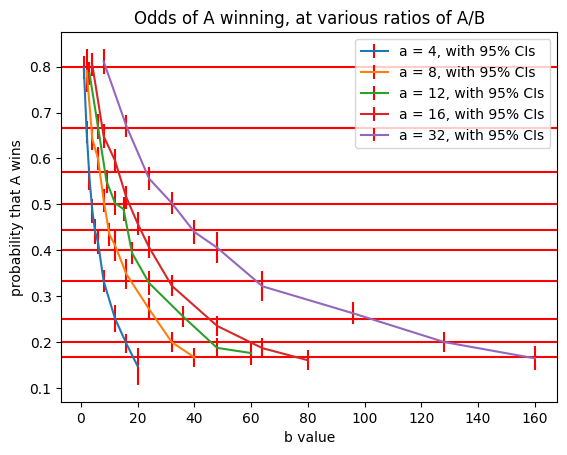

In [194]:
# now, simulating and plotting out the probabilities of A winning

a_values = [4, 8, 12, 16, 32]

for i in range(len(a_values)):
  a_val = a_values[i]

  b_values = [a_val * 0.25, a_val * 0.5, a_val * 0.75, a_val, a_val * 1.25, a_val * 1.5, a_val * 2, a_val * 3, a_val * 4, a_val * 5]

  est = []
  std = []

  for j in range(len(b_values)):
    # pilot run
    results = []
    for k in range(20):
      results.append(gamble(a_val, b_values[j])[0])

    std_k = np.std(results)


    # changing N so the sample size decreases -- CI fitting to half-width of 0.05
    N = int(np.ceil(1.96**2 * std_k**2 / (0.025**2)))

    # real run
    results = []
    for k in range(N):
      results.append(gamble(a_val, b_values[j])[0])

    # get statistics
    mu_N = np.mean(results)
    std_N = np.std(results)


    # store the value for plotting
    # store the standard deviation for the CI
    est.append(mu_N)
    std.append(std_N / np.sqrt(N))


  # plot the simulated odds of winning for this value of a
  #plt.plot(b_values, est, label = 'a = {}'.format(a_val))
  # add the 95% confidence intervals!
  plt.errorbar(b_values, est, yerr = 1.96 * np.array(std), ecolor = 'red', label = 'a = {}, with 95% CIs'.format(a_val))

  plt.legend()
  plt.xlabel("b value")
  plt.ylabel("probability that A wins")
  plt.title("Odds of A winning, at various ratios of A/B")

plt.axhline(y= 4 / 5, color='r', linestyle='-')
plt.axhline(y= 4 / 6, color='r', linestyle='-')
plt.axhline(y= 4 / 7, color='r', linestyle='-')
plt.axhline(y= 4 / 8, color='r', linestyle='-')
plt.axhline(y= 4 / 9, color='r', linestyle='-')
plt.axhline(y= 4 / 10, color='r', linestyle='-')
plt.axhline(y= 4 / 12, color='r', linestyle='-')
plt.axhline(y= 4 / 16, color='r', linestyle='-')
plt.axhline(y= 4 / 20, color='r', linestyle='-')
plt.axhline(y= 4 / 24, color='r', linestyle='-')

plt.show()

As it should be evident, the CIs all contain the ratio $\frac{a}{a+b}!$

___
**(b)** Another question we can ask is how long it takes for the tournament to end. To study this, simulate the gambler's ruin for a range of values of $a$ and $b$, and use this to try and guess the expected time to ruin.

*Hint: Convince yourself that the function must be symmetric in $a$ and $b$, so you can assume $a\leq b$. Try plotting the expected absorption times for selected values of $a$, while varying $b$.*

___

## Ans.

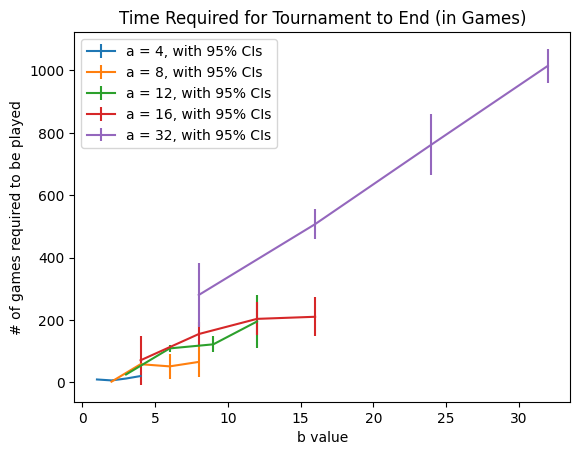

In [229]:
# now, simulating

a_values = [4, 8, 12, 16]

for i in range(len(a_values)):
  a_val = a_values[i]

  b_values = [a_val * 0.25, a_val * 0.5, a_val * 0.75, a_val]

  est = []
  std = []

  for j in range(len(b_values)):
    # pilot run
    results = []
    for k in range(20):
      results.append(gamble(a_val, b_values[j])[1])

    std_k = np.std(results)


    # changing N so the sample size decreases -- CI fitting to half-width of 0.05
    N = int(np.ceil(1.96**2 * std_k**2 / (50**2)))

    # real run
    results = []
    for k in range(N):
      results.append(gamble(a_val, b_values[j])[1])

    # get statistics
    mu_N = np.mean(results)
    std_N = np.std(results)


    # store the value for plotting
    # store the standard deviation for the CI
    est.append(mu_N)
    std.append(std_N / np.sqrt(N))


  # plot the simulated odds of winning for this value of a
  #plt.plot(b_values, est, label = 'a = {}'.format(a_val))
  # add the 95% confidence intervals!
  plt.errorbar(b_values, est, yerr = 1.96 * np.array(std), label = 'a = {}, with 95% CIs'.format(a_val))

  plt.legend()
  plt.xlabel("b value")
  plt.ylabel("# of games required to be played")
  plt.title("Time Required for Tournament to End (in Games)")

Roughly, it seems that for any fixed value of $a$, the number of games that needs to be played is dependent on $b$, and is directly linearly proportional to that.

Given exactly where the CIs tend to lie, it seems as if the expected number of games needed to be played is roughly equal to $ab$? That would be my best guess, anyway.

___
___

# Question 4: Simulation assigments take forever (25 points)

You are convinced that Simulation homeworks take the longest time compared to all other assignments, while Sid maintains that all assignment times are identically distributed. To decide this debate once and for all, you decide to record how long it takes you to do your assignment, and then survey your friends on how long it took them to do their last assignment until you find someone who took longer$\ldots$

___

**(a)**
Suppose Sid is right (!) and all assignment completion times are truly identically distributed. Formally suppose your own assignment takes time (in hours) distributed as $T_0\sim Exp(0.5)$, and similarly the $i^{th}$ friend you survey also takes time $T_i\sim Exp(0.5)$, independent of all other friends. Run 100 simulations and report a $95\%$ CI for the expected number of friends you need to survey to find someone who takes longer.
___


## Ans.


In [220]:
# first, the simulation code itself

def assignment():
  surveys = []
  your_time = np.random.exponential(1/0.5)

  while True:
    friend_time = np.random.exponential(1/0.5)
    surveys.append(friend_time)

    if(friend_time > your_time):
      break

  return len(surveys)

In [226]:
# now, running 100 simulations
results = []
for i in range(100):
  results.append(assignment())

mu_N = np.sum(results) / len(custs)
std_N = np.std(results) / np.sqrt(len(custs))


lower_bound = mu_N - 1.96 * std_N
upper_bound = mu_N + 1.96 * std_N

print("95% confidence interval: ({:.4f},{:.4f})".format(lower_bound, upper_bound))

95% confidence interval: (-0.9547,3.5027)


So the 95% confidence interval for the true number of friends required to find a friend taking longer than you is between -0.9547 friends, and 3.5027 friends.

___

**(b)** You are concerned that the CI looks a little wide, so decide to do more replications to fix the problem. Repeat the above simulation with number of replications $n\in\{100,500,1000,1500,2000,2500,\ldots,9500,10000\}$, and plot the estimates and $95\%$ CIs.
___

## Ans.


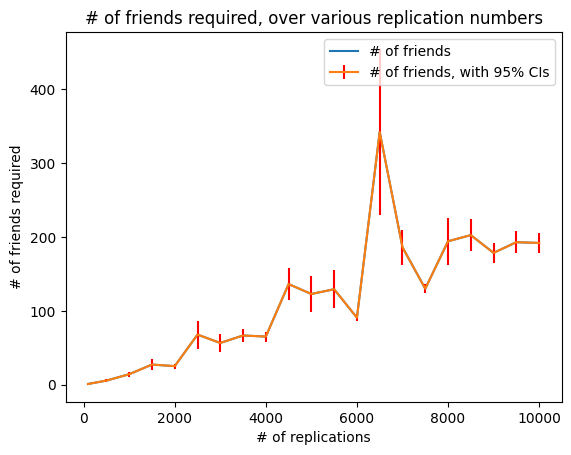

In [225]:
Ns = [100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500,10000]
est = []
std = []

for n in [100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500,10000]:
  results = []
  for i in range(n):
    results.append(assignment())

  mu_N = np.sum(results) / len(custs)
  std_N = np.std(results) / np.sqrt(len(custs))

  est.append(mu_N)
  std.append(std_N)

plt.plot(Ns, est, label = "# of friends")
plt.errorbar(Ns, est, yerr = 1.96 * np.array(std), ecolor = 'red', label = '# of friends, with 95% CIs')

plt.legend()
plt.xlabel("# of replications")
plt.ylabel("# of friends required")
plt.title("# of friends required, over various replication numbers")

plt.show()

___
**(c)** Hopefully you found the previous part a little surprising(?) Why is that the case? Well, this question highlights an important aspect of simulation that we have taken for granted in past problems -- in order to get an estimator for an unknown quantity, we *need that quantity to be finite*! Find an expression for computing the expected number of queries till we get one which is larger in the above setting, and argue that it is infinite.

*Hint: Remember how we used linearity of expectation and indicator random variables before? Try doing the same, with indicator variables for the $i^{th}$ person (for each $i\in\{1,2,\ldots\}$) being the first person surveyed who took longer than you).*
___


## Ans.

Here, we are interested in finding

$$E[\text{# of people until you get the first person taking longer than you}]
= \mathbb{1}_i * \sum_{i = 1}^{\infty}P(Exp(0.5)_i > T_0) * P(Exp(0.5)_{0...i-1} <= T_0)$$, but there's an issue with this:

namely, for any $Exp(\lambda)$, the pdf is monotonic decreasing -- and that means that $P(Exp(0.5)_i > T_0)$ is always less than $P(Exp(0.5)_{0...i-1} <= T_0)$ since you're always more likely to get value smaller than $T_0$ as opposed to larger than $T_0$, and this means that it only gets *harder and harder* to find a larger value as the number of friends continues to increase.

Thus, this series is infinite -- and we don't get any convergence on the number of friends needed.